In [1]:
import cobra
from cobra.io import read_sbml_model
from cobra import Reaction, Metabolite, Model
import cameo
from cameo import phenotypic_phase_plane
from cameo import models
from cameo.visualization.plotting.with_plotly import PlotlyPlotter
plotter = PlotlyPlotter()
from cameo import load_model
from cameo import phenotypic_phase_plane
from cameo.strain_design import OptGene

In [2]:
modelM=read_sbml_model("iJN678mod.xml")
modelMVA=read_sbml_model("iJN678mva.xml")

Restricted license - for non-production use only - expires 2024-10-28


KeyboardInterrupt: 

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas

To assess the possible gene knockouts, the OptGene algorithm has been run. From the results, the top five strain designs have been analysed in terms of maximum yield, plotting the phenotypic phase planes for each. However, it must be noted that, due to complications during the running of the algorithm, the reaction here studied is the first of the pathwya, that is, Pyruvate Kinase. An increase in its flux will increase the flux of the whole pathway, thus producing more squalene.

In [ ]:
optgene = OptGene(modelM)

In [ ]:
result = optgene.run(target=modelM.reactions.PYK,
                     biomass=modelM.reactions.BIOMASS_Ec_SynHetero,
                     substrate=modelM.metabolites.glc__D_e,
                     max_evaluations=5000,
                     plot=False)
result

In [ ]:
result.plot(plotter, result[0])

In [ ]:
result.plot(plotter, result[1])

In [ ]:
#result.plot(plotter, 2)

In [ ]:
#result.plot(plotter, 3)

In [ ]:
#result.plot(plotter, 4)

Similarly, the same process was conducted with the model with the MVA pathway. This time, also using the first reaction of the pathway, Acetyl-CoA C-acetyltransferase, due to the same computational limitations.

In [ ]:
optgene = OptGene(modelMVA)

In [ ]:
result = optgene.run(target=modelMVA.reactions.R_MVA0,
                     biomass=modelMVA.reactions.BIOMASS_Ec_SynHetero,
                     substrate=modelMVA.metabolites.glc__D_e,
                     max_evaluations=5000,
                     plot=False)
result

In [ ]:
result.plot(plotter, 0)

In [ ]:
result.plot(plotter, 1)

In [ ]:
result.plot(plotter, 2)

In [ ]:
result.plot(plotter, 3)

In [ ]:
result.plot(plotter, 4)

In [ ]:
result.plot(plotter, 5)

In [3]:
import numpy as np
from tqdm import tqdm

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import cobra
from cobra.io import load_model
model = read_sbml_model('iJN678mod.xml')

In [5]:
def add_dynamic_bounds(model, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    biomass, glucose = y  # expand the boundary species
    glucose_max_import = -10 * glucose / (5 + glucose)
    model.reactions.EX_glc__D_e.lower_bound = glucose_max_import


def dynamic_system(t, y):
    """Calculate the time derivative of external species."""

    biomass, glucose = y  # expand the boundary species

    # Calculate the specific exchanges fluxes at the given external concentrations.
    with model:
        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)
        lex_constraints = cobra.util.add_lexicographic_constraints(
            model, ['BIOMASS_Ec_SynHetero', 'EX_glc__D_e'], ['max', 'max'])

    # Since the calculated fluxes are specific rates, we multiply them by the
    # biomass concentration to get the bulk exchange rates.
    fluxes = lex_constraints.values
    fluxes *= biomass

    # This implementation is **not** efficient, so I display the current
    # simulation time using a progress bar.
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description('t = {:.3f}'.format(t))

    return fluxes

dynamic_system.pbar = None


def infeasible_event(t, y):
    """
    Determine solution feasibility.

    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function re-solves the LP to determine whether or not the solution is feasible
    (and if not, how far it is from feasibility). When the sign of this function changes
    from -epsilon to positive, we know the solution is no longer feasible.

    """

    with model:

        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)

    return feasibility - infeasible_event.epsilon

infeasible_event.epsilon = 1E-6
infeasible_event.direction = 1
infeasible_event.terminal = True

In [6]:
model.solver = 'glpk'

ts = np.linspace(0, 5, 50)  # Desired integration resolution and interval
y0 = [0.1, 10]

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method='BDF'
    )

t = 5.000: : 146it [05:17,  2.18s/it]


In [7]:
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 143
     njev: 1
      nlu: 13
      sol: None
   status: 0
  success: True
        t: array([0.        , 0.10204082, 0.20408163, 0.30612245, 0.40816327,
       0.51020408, 0.6122449 , 0.71428571, 0.81632653, 0.91836735,
       1.02040816, 1.12244898, 1.2244898 , 1.32653061, 1.42857143,
       1.53061224, 1.63265306, 1.73469388, 1.83673469, 1.93877551,
       2.04081633, 2.14285714, 2.24489796, 2.34693878, 2.44897959,
       2.55102041, 2.65306122, 2.75510204, 2.85714286, 2.95918367,
       3.06122449, 3.16326531, 3.26530612, 3.36734694, 3.46938776,
       3.57142857, 3.67346939, 3.7755102 , 3.87755102, 3.97959184,
       4.08163265, 4.18367347, 4.28571429, 4.3877551 , 4.48979592,
       4.59183673, 4.69387755, 4.79591837, 4.89795918, 5.        ])
 t_events: [array([], dtype=float64)]
        y: array([[ 0.1       ,  0.1051779 ,  0.11061035,  0.11630841,  0.12228333,
         0.12854661,  0.135

Text(0, 0.5, 'Glucose')

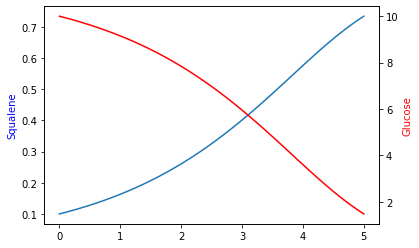

In [8]:
ax = plt.subplot(111)
ax.plot(sol.t, sol.y.T[:, 0])
ax2 = plt.twinx(ax)
ax2.plot(sol.t, sol.y.T[:, 1], color='r')

ax.set_ylabel('Squalene', color='b')
ax2.set_ylabel('Glucose', color='r')

In [9]:
def add_dynamic_bounds(model, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    sql_e, glucose = y  # expand the boundary species
    glucose_max_import = -10 * glucose / (5 + glucose)
    model.reactions.EX_glc__D_e.lower_bound = glucose_max_import


def dynamic_system(t, y):
    """Calculate the time derivative of external species."""

    sql_e, glucose = y  # expand the boundary species

    # Calculate the specific exchanges fluxes at the given external concentrations.
    with model:
        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)
        lex_constraints = cobra.util.add_lexicographic_constraints(
            model, ['EX_sql_e', 'EX_glc__D_e'], ['max', 'max'])

    # Since the calculated fluxes are specific rates, we multiply them by the
    # biomass concentration to get the bulk exchange rates.
    fluxes = lex_constraints.values
    fluxes *= sql_e

    # This implementation is **not** efficient, so I display the current
    # simulation time using a progress bar.
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description('t = {:.3f}'.format(t))

    return fluxes

dynamic_system.pbar = None


def infeasible_event(t, y):
    """
    Determine solution feasibility.

    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function re-solves the LP to determine whether or not the solution is feasible
    (and if not, how far it is from feasibility). When the sign of this function changes
    from -epsilon to positive, we know the solution is no longer feasible.

    """

    with model:

        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)

    return feasibility - infeasible_event.epsilon

infeasible_event.epsilon = 1E-6
infeasible_event.direction = 1
infeasible_event.terminal = True

In [10]:
model.solver = 'glpk'

ts = np.linspace(0, 5, 10)  # Desired integration resolution and interval
y0 = [0.1, 10]

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method='BDF'
    )

t = 5.000: : 212it [08:00,  2.27s/it]


Text(0, 0.5, 'Glucose')

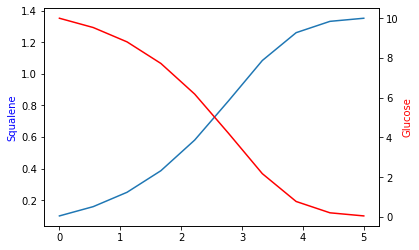

In [11]:
ax = plt.subplot(111)
ax.plot(sol.t, sol.y.T[:, 0])

ax2 = plt.twinx(ax)
ax2.plot(sol.t, sol.y.T[:, 1], color='r')

ax.set_ylabel('Squalene', color='b')
ax2.set_ylabel('Glucose', color='r')

In [12]:
model.metabolites.get_by_id("glc__D_e")

Metabolite identifier,glc__D_e
Name,D-Glucose
Memory address,0x2418b808340
Formula,C6H12O6
Compartment,e
In 2 reaction(s),"EX_glc__D_e, GLCtex"
